# Keyphrases Graphs

In [67]:
%matplotlib inline 

import networkx as nx 
import seaborn as sns
import graph_tool.all as gt 
import matplotlib.pyplot as plt 

from datetime import datetime 
from collections import Counter, defaultdict
from dateutil.parser import parse as dateparse 
from colors import ColorMap
from operator import itemgetter

In [2]:
sns.set_context('talk')
sns.set_style('whitegrid')

In [3]:
g = gt.load_graph('data/tiny_keyphrases.graphml.gz')

In [23]:
h = gt.load_graph('data/email_multigraph.gt')
print gt_info(h)

Type: Graph
Number of nodes: 6,174
Number of edges: 343,702
Average degree:  111.339𝜇 10.725𝜎


In [4]:
def gt_info(g):
    """
    Prints out an info statement similar to networkx. 
    
        Name: Baleen Keyphrase Graph
        Type: Graph
        Number of nodes: 139227
        Number of edges: 257316
        Average degree:   3.6964
    
    Uses an simple format string to do this. 
    """
    
    # Set up the output
    output = []
        
    # Append the graph string properties 
    for key in g.gp.keys(): 
        output.append("{}: {}".format(key.title(), g.gp[key]))
    
    
    # Detect the graph type 
    graph_type = "DiGraph" if g.is_directed() else "Graph"
    output.append("Type: {}".format(graph_type))
    
    # Add the number of nodes and edges 
    output.append("Number of nodes: {:,}".format(g.num_vertices()))
    output.append("Number of edges: {:,}".format(g.num_edges()))
    
    # Add the average degree and standard deviation 
    output.append("Average degree:  {:0.3f}𝜇 {:0.3f}𝜎".format(*gt.vertex_average(g, 'total')))
    
    # Return the info string 
    return "\n".join(output)

In [5]:
print gt_info(g)

Name: Baleen Keyphrase Graph
Type: Graph
Number of nodes: 139,227
Number of edges: 257,316
Average degree:  3.696𝜇 0.054𝜎


In [6]:
gtypes = Counter(g.vp.type[v] for v in g.vertices())

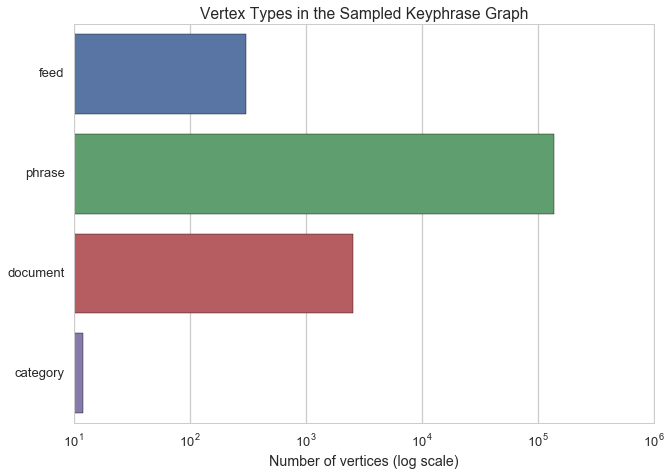

In [7]:
def plot_vertex_types(outpath):
    g = sns.barplot(y=gtypes.keys(), x=gtypes.values(), log=True)
    g.set_title("Vertex Types in the Sampled Keyphrase Graph")
    g.set_xlabel("Number of vertices (log scale)")

    plt.savefig(outpath)

plot_vertex_types("images/keyphrase_vertex_type.png")

In [8]:
def degree_filter(degree=0):
    def inner(vertex):
        return vertex.out_degree() > degree 
    return inner 

g = gt.GraphView(g, vfilt=degree_filter(3))

In [9]:
print gt_info(g)

Name: Baleen Keyphrase Graph
Type: Graph
Number of nodes: 8,520
Number of edges: 112,320
Average degree:  26.366𝜇 0.452𝜎


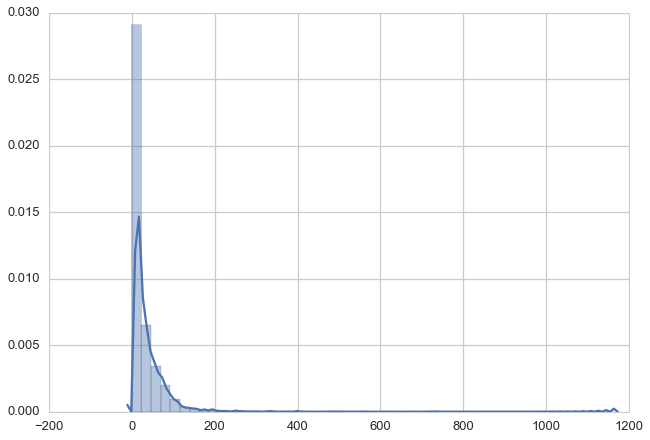

In [10]:
sns.distplot([v.out_degree() for v in g.vertices()], norm_hist=True)

## Document View

In [29]:
import random 

def ego_filter(g, ego, hops=2):
    def inner(vertex):
        return gt.shortest_distance(g, ego, vertex) <= hops 
    return inner

In [ ]:
# Get a random document 
v = random.choice([v for v in g.vertices() if g.vp.type[v] == 'document'])

In [28]:
ego = gt.GraphView(g, vfilt=ego_filter(g,v, 1))
print gt_info(ego)

Name: Baleen Keyphrase Graph
Type: Graph
Number of nodes: 74
Number of edges: 73
Average degree:  1.973𝜇 0.966𝜎


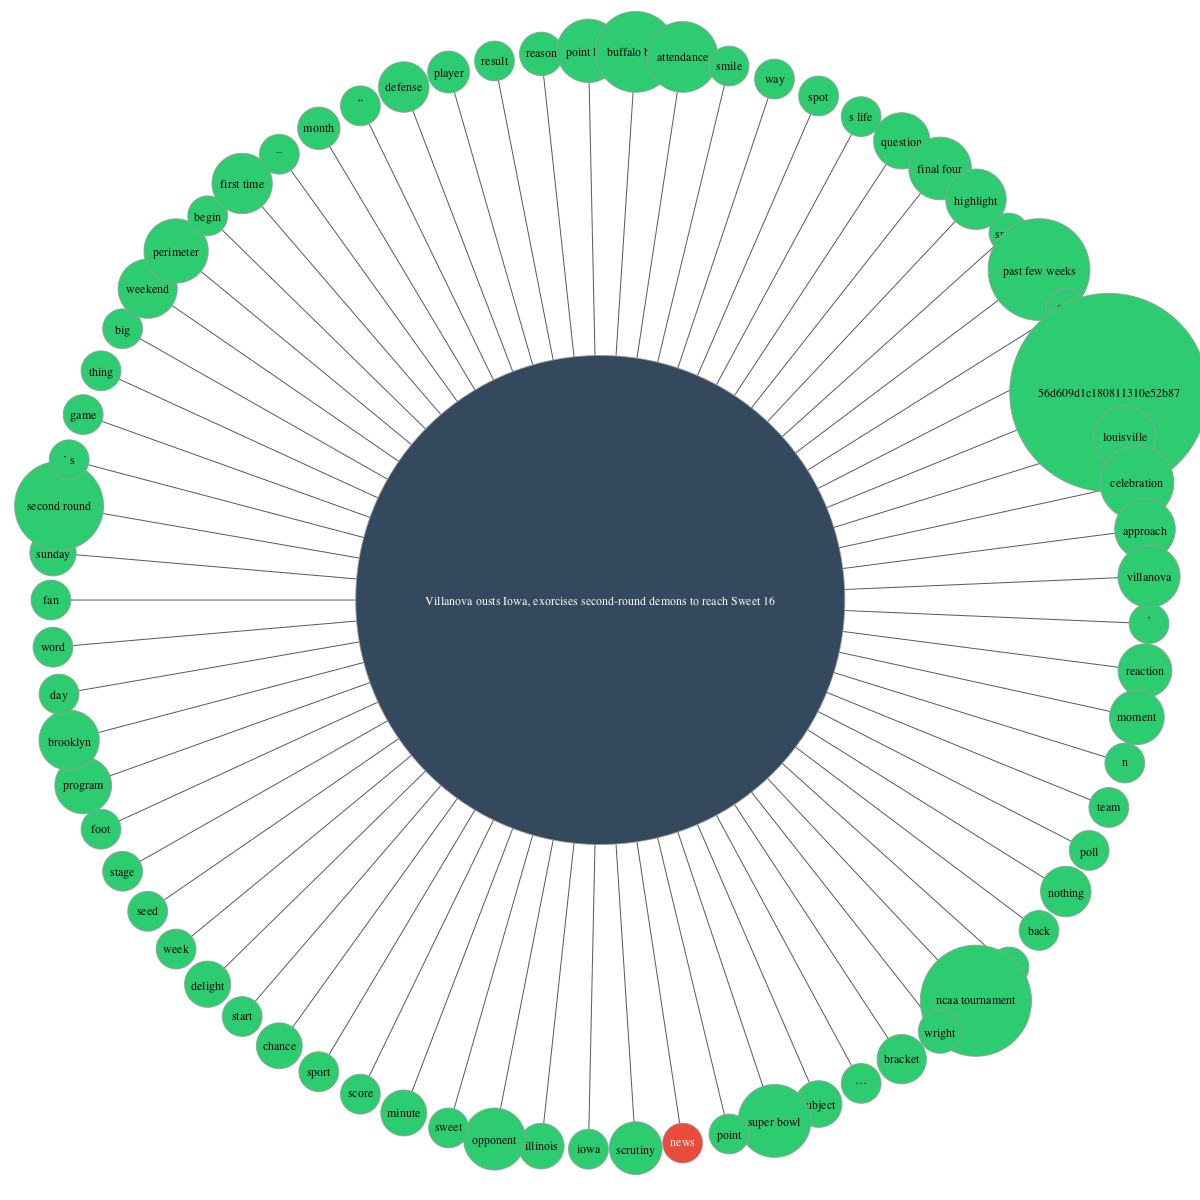

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12d380fd0, at 0x123beff90>

In [30]:
doc = ego.vp.title[v].replace(' ', '-').lower()

# Set the vertex label 
vlabel  = ego.new_vertex_property('string')
for vertex in ego.vertices():
    if ego.vp.type[vertex] in ('document', 'feed'):
        vlabel[vertex] = ego.vp.title[vertex]
    elif ego.vp.type[vertex] == 'phrase':
        vlabel[vertex] = ego.vp.phrase[vertex]
    else:
        vlabel[vertex] = ego.vp._graphml_vertex_id[vertex]

vsize = ego.new_vertex_property('int')
for vertex in ego.vertices():
    vsize[vertex] = len(vlabel[vertex])

# Set the vertex color 
vcolor  = ego.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in ego.vertices():
    vcolor[vertex] = vcmap(ego.vp['type'][vertex])

gt.graph_draw(ego, pos=gt.radial_tree_layout(ego, v),
    vertex_text=vlabel, vertex_shape='none', vertex_pen_width=1,
#     vertex_font_size=22, vertex_size=vsize,
    vertex_fill_color=vcolor, output_size=(1200,1200), 
    output='images/{}.png'.format(doc)
)

## Centrality of Time

In [88]:
# Construct Time Structures to Keyphrase 
h = gt.Graph(directed=False) 
h.gp.name = h.new_graph_property('string') 
h.gp.name = "Phrases by Week"


# Add vertex properties
vcmap   = ColorMap('flatui', shuffle=False)
h.vp.weekno = h.new_vertex_property('int')
h.vp.label = h.new_vertex_property('string')
h.vp.text  = h.new_vertex_property('string')
h.vp.color = h.new_vertex_property('string')
h.vp.vtype = h.new_vertex_property('string')

# Create graph from the keyphrase graph 
vidmap  = {}
for vertex in g.vertices():
    if g.vp.type[vertex] == 'document':
        dt = g.vp.pubdate[vertex]
        if not dt: continue 

        dt = float(dt) / 1000.0 
        dt = datetime.fromtimestamp(dt) 
        weekno = dt.isocalendar()[1]
        
        if weekno not in vidmap:
            vidmap[weekno] = h.add_vertex()
            h.vp.label[vidmap[weekno]] = "Week {}".format(weekno)
            h.vp.color[vidmap[weekno]] = vcmap('week')
            h.vp.vtype[vidmap[weekno]] = 'week'
            h.vp.weekno[vidmap[weekno]] = weekno
        
        week = vidmap[weekno]
        for neighbor in vertex.out_neighbours():
            if g.vp.type[neighbor] == 'phrase':
                
                if g.vp.phrase[neighbor] not in vidmap: 
                    phrase = g.vp.phrase[neighbor]
                    vidmap[phrase] = h.add_vertex()
                    h.vp.text[vidmap[phrase]] = phrase
                    h.vp.color[vidmap[phrase]] = vcmap('phrase')
                    h.vp.vtype[vidmap[phrase]] = 'phrase'
                    
                phrase = vidmap[g.vp.phrase[neighbor]]
                h.add_edge(week, phrase)

print gt_info(h)

Name: Phrases by Week
Type: Graph
Number of nodes: 6,074
Number of edges: 107,291
Average degree:  35.328𝜇 5.001𝜎


In [89]:
h.save('data/keyphrases_by_week.gt')

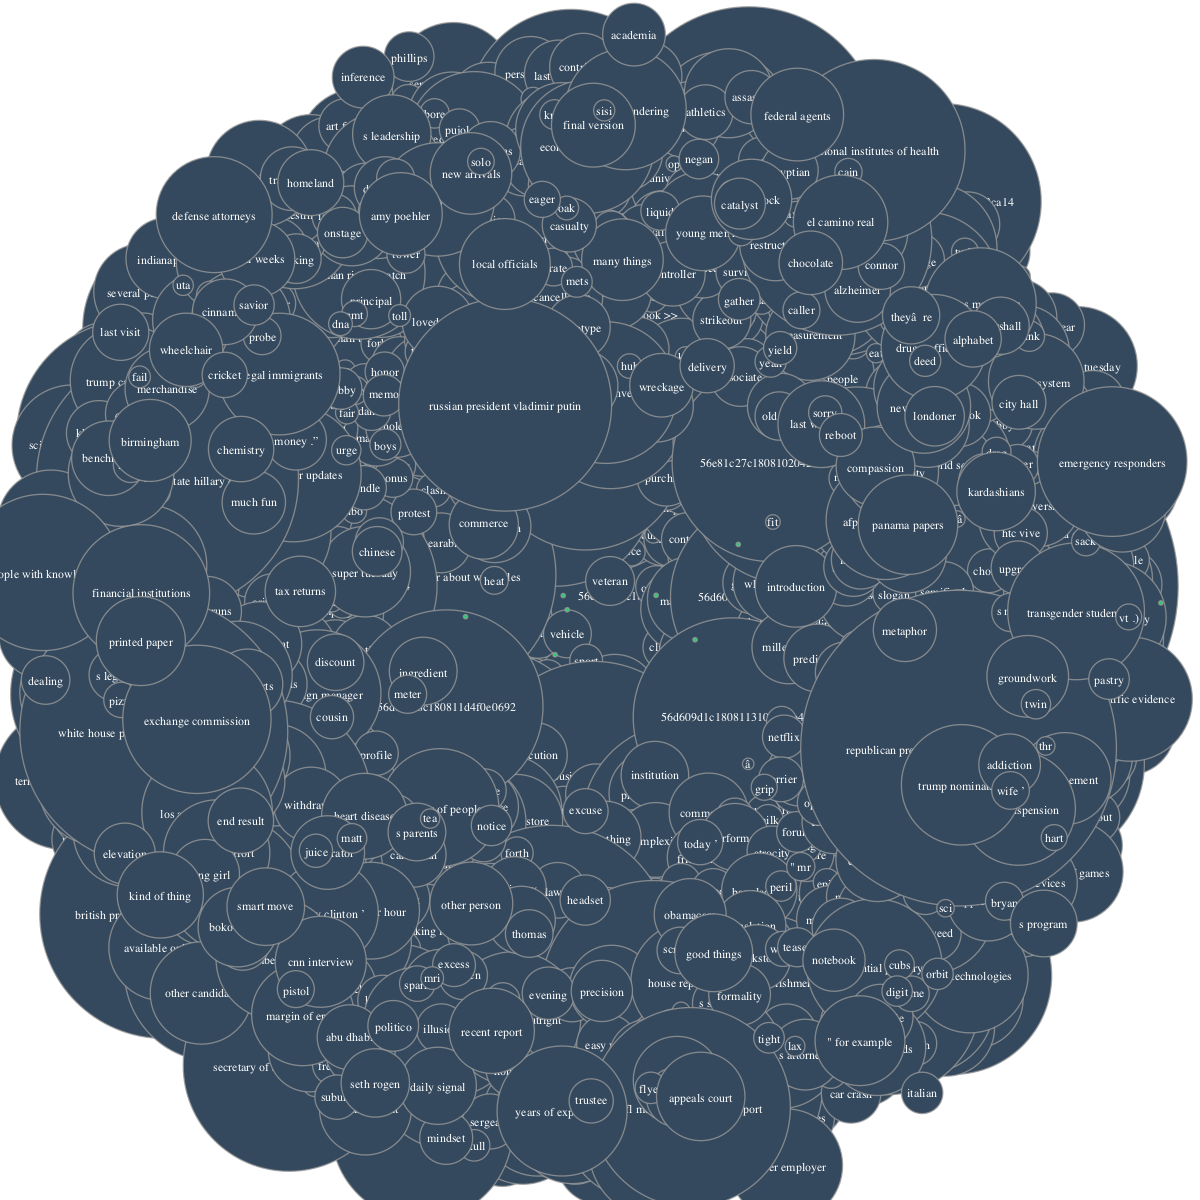

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x123493850, at 0x1234ed710>

In [58]:
gt.graph_draw(h, 
    vertex_fill_color=h.vp.color, vertex_text=h.vp.text, vertex_pen_width=1.3, 
    edge_pen_width=0.4, edge_pen_color="#cccccc", 
    output_size=(1200,1200), output="images/words_blob.png",
)

In [79]:
def rank_time(g, vprop):
    weeks = {}
    ranks = defaultdict(list)
    for vertex in g.vertices():
        if g.vp.vtype[vertex] == 'week':
            weeks[g.vp.label[vertex]] = vprop[vertex]
            
            for neighbor in vertex.out_neighbours():
                ranks[g.vp.label[vertex]].append(
                    (g.vp.text[neighbor], vprop[neighbor])
                )
    
    weeks = sorted(weeks.items(), key=itemgetter(1))
    for week, score in weeks:
        print("{}:".format(week))
        phrases = sorted(ranks[week], key=itemgetter(1))
        for phrase, pscore in phrases[:5]:
            print("    - {}".format(phrase))
        print("")

In [90]:
h.vp.betweenness = h.new_vertex_property('double')
h.ep.betweenness = h.new_edge_property('double')
h.vp.betweenness, h.ep.betweenness = gt.betweenness(h)

In [80]:
rank_time(h, h.vp.betweenness)

Week 40:
    - steam
    - roll
    - october
    - anything

Week 2:
    - edit
    - reading
    - craft
    - comfort
    - equivalent

Week 45:
    - turnout
    - democratic
    - undocumented immigrants
    - big issue
    - alabama

Week 5:
    - much attention
    - great deal
    - disadvantage
    - same people
    - female

Week 1:
    - rose
    - local
    - pastry
    - dessert
    - lemon

Week 50:
    - stir
    - spinach
    - oven
    - bake
    - lid

Week 49:
    - demagogue
    - “ nobody
    - university of illinois
    - islamic state ’
    - thursday evening

Week 7:
    - data visualization
    - data visualization
    - leisure
    - attribute
    - longevity

Week 4:
    - noodle
    - goodness
    - great idea
    - ve become
    - jar

Week 8:
    - good start
    - 56d609d1c180811310e52c3d
    - notebook
    - long shot
    - addiction

Week 21:
    - emergency responders
    - emergency responders
    - greek authorities
    - smooth
    - vw

Week 12:
  

In [91]:
h.vp.page_rank = h.new_vertex_property('double')
h.vp.page_rank = gt.katz(h)

In [85]:
rank_time(h, h.vp.page_rank)

Week 18:
    - data
    - september
    - other words
    - lot
    - follow tech insider on facebook

Week 19:
    - age
    - adult
    - question
    - bathroom
    - woman

Week 50:
    - pepper
    - yesterday
    - sleep
    - quarter
    - moment

Week 10:
    - citizen
    - monopoly
    - finance
    - big
    - efficiency

Week 11:
    - future
    - time
    - george
    - thing
    - darker

Week 12:
    - s time
    - order
    - first step
    - place
    - press

Week 13:
    - ceiling
    - read
    - trump ’
    - information
    - woman

Week 14:
    - sweep
    - party
    - delegate
    - twitter
    - comment

Week 15:
    - world
    - photograph
    - blast
    - ukraine
    - decade

Week 16:
    - time
    - second
    - artists
    - aside
    - artist

Week 17:
    - school
    - george
    - worker
    - myth
    - fact

Week 21:
    - order
    - last time
    - super bowl
    - venue
    - st

Week 20:
    - age
    - class
    - centre
    - family
    - 

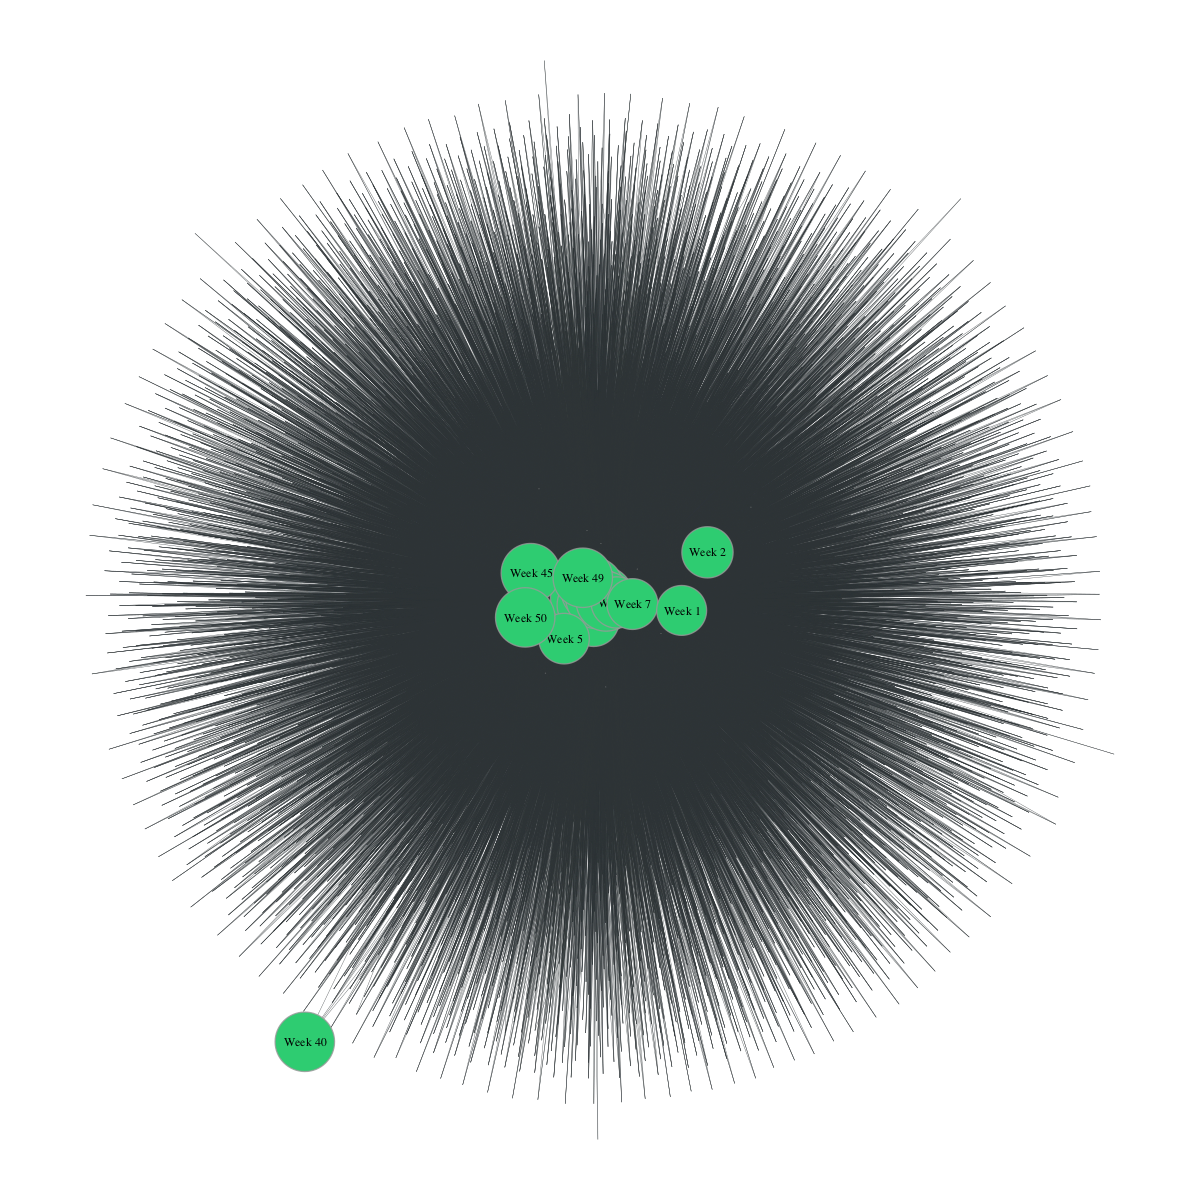

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x123493850, at 0x123f01590>

In [62]:
gt.graph_draw(h, 
    vertex_fill_color=h.vp.color, vertex_size=h.vp.betweenness, 
    vertex_pen_width=1.3, vertex_text=h.vp.label,
    edge_pen_width=0.4, edge_pen_color="#cccccc", 
    output_size=(1200,1200), output="images/keyphrase_betweenness.png",
)

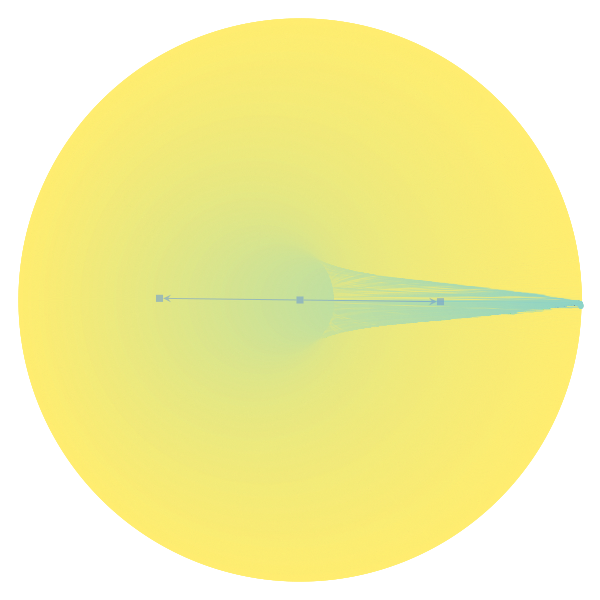

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x123493850, at 0x124022c90>,
 <Graph object, directed, with 6077 vertices and 6076 edges at 0x124069150>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x124069150, at 0x124069610>)

In [63]:
state = gt.minimize_nested_blockmodel_dl(h, deg_corr=True)
gt.draw_hierarchy(state, output='images/keyphrase_hierarchy.png')

In [93]:
weeks = [
    v for v in h.vertices() if h.vp.vtype[v] == 'week'
]
weeks.sort(key=lambda v: h.vp.weekno[v])

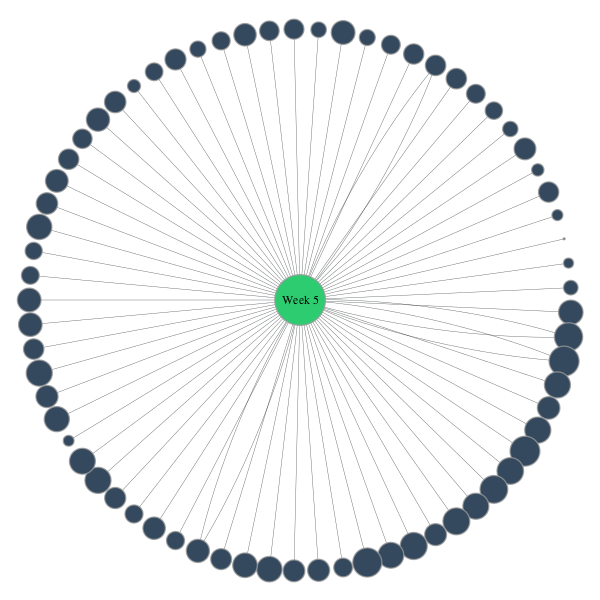

In [116]:
def display_ego_for_time(g, week):
    view = gt.GraphView(g, vfilt=ego_filter(g, week, 1))
    vsize = gt.prop_to_size(view.vp.betweenness, mi=2, ma=30, log=True)
    pos = gt.radial_tree_layout(view, week)
    gt.graph_draw(view, pos=pos, 
        vertex_fill_color=view.vp.color, vertex_size=vsize,
        vertex_pen_width=1.3, vertex_text=view.vp.label,
        edge_pen_width=0.4, edge_pen_color="#cccccc",
        output="images/{}.png".format(view.vp.label[week])
    )
    
display_ego_for_time(h, weeks[3])